# OBJECT DETECTION USING TENSORFLOW

Run this using GPU Runtime for faster results

In [0]:
# For running inference on the TF-Hub module.
import tensorflow as tf
import tensorflow_hub as hub


# For loading the image.
import matplotlib.pyplot as plt
import tempfile
from six import BytesIO

# For drawing onto the image.
import numpy as np
from PIL import Image
from PIL import ImageColor
from PIL import ImageDraw
from PIL import ImageFont
from PIL import ImageOps

import time


Some important functions

In [0]:
def display_image(image):
  fig = plt.figure(figsize=(20, 15))
  plt.grid(False)
  plt.imshow(image)


def load_and_resize_image(url, new_width=256, new_height=256,
                              display=False):
  _, filename = tempfile.mkstemp(suffix=".jpg")
  with open(url, "rb") as response:
    image_data = response.read()
  image_data = BytesIO(image_data)
  pil_image = Image.open(image_data)
  pil_image = ImageOps.fit(pil_image, (new_width, new_height), Image.ANTIALIAS)
  pil_image_rgb = pil_image.convert("RGB")
  pil_image_rgb.save(filename, format="JPEG", quality=90)
  print("Image saved to %s." % filename)
  if display:
    display_image(pil_image)
  return filename


def draw_bounding_box_on_image(image,
                               ymin,
                               xmin,
                               ymax,
                               xmax,
                               color,
                               font,
                               thickness=4,
                               display_str_list=()):
  draw = ImageDraw.Draw(image)
  im_width, im_height = image.size
  (left, right, top, bottom) = (xmin * im_width, xmax * im_width,
                                ymin * im_height, ymax * im_height)
  draw.line([(left, top), (left, bottom), (right, bottom), (right, top),
             (left, top)],
            width=thickness,
            fill=color)


  display_str_heights = [font.getsize(ds)[1] for ds in display_str_list]
  total_display_str_height = (1 + 2 * 0.05) * sum(display_str_heights)

  if top > total_display_str_height:
    text_bottom = top
  else:
    text_bottom = bottom + total_display_str_height
    
  for display_str in display_str_list[::-1]:
    text_width, text_height = font.getsize(display_str)
    margin = np.ceil(0.05 * text_height)
    draw.rectangle([(left, text_bottom - text_height - 2 * margin),
                    (left + text_width, text_bottom)],
                   fill=color)
    draw.text((left + margin, text_bottom - text_height - margin),
              display_str,
              fill="black",
              font=font)
    text_bottom -= text_height - 2 * margin


def draw_boxes(image, boxes, class_names, scores, max_boxes=10, min_score=0.1):

  colors = list(ImageColor.colormap.values())
  font = ImageFont.load_default()

  for i in range(min(boxes.shape[0], max_boxes)):
    if scores[i] >= min_score:
      ymin, xmin, ymax, xmax = tuple(boxes[i].tolist())
      display_str = "{}: {}%".format(class_names[i].decode("ascii"),
                                     int(100 * scores[i]))
      color = colors[hash(class_names[i]) % len(colors)]
      image_pil = Image.fromarray(np.uint8(image)).convert("RGB")
      draw_bounding_box_on_image(
          image_pil,
          ymin,
          xmin,
          ymax,
          xmax,
          color,
          font,
          display_str_list=[display_str])
      np.copyto(image, np.array(image_pil))
  return image

*Loading the Image from PATH*

Image saved to /tmp/tmp325h5hdd.jpg.


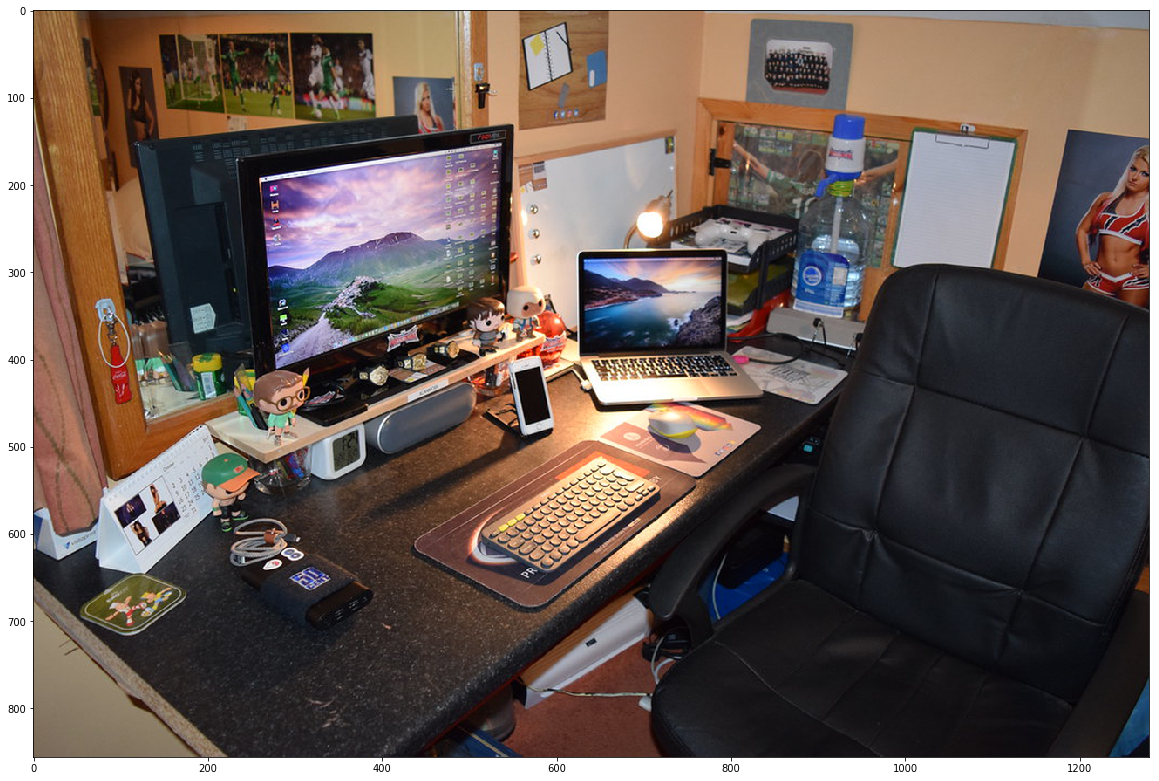

In [10]:
image_url = "image.jpg"
load_image_path = load_and_resize_image(image_url, 1280, 856, True)

## **Real fun begins**

In [0]:
module_handle = "https://tfhub.dev/google/faster_rcnn/openimages_v4/inception_resnet_v2/1" 
with tf.Graph().as_default():
  detector = hub.Module(module_handle)
  image_string_placeholder = tf.placeholder(tf.string)
  decoded_image = tf.image.decode_jpeg(image_string_placeholder)
  decoded_image_float = tf.image.convert_image_dtype(
      image=decoded_image, dtype=tf.float32)
  module_input = tf.expand_dims(decoded_image_float, 0)
  result = detector(module_input, as_dict=True)
  init_ops = [tf.global_variables_initializer(), tf.tables_initializer()]

  session = tf.Session()
  session.run(init_ops)

  with tf.gfile.Open(load_image_path, "rb") as binfile:
    image_string = binfile.read()

  result_out, image_out = session.run(
      [result, decoded_image],
      feed_dict={image_string_placeholder: image_string})
  print("Found %d objects." % len(result_out["detection_scores"]))
image_with_boxes = draw_boxes(
    np.array(image_out), result_out["detection_boxes"],
    result_out["detection_class_entities"], result_out["detection_scores"])

display_image(image_with_boxes)

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0613 12:18:05.583530 140453542057856 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0613 12:18:32.171942 140453542057856 saver.py:1483] Saver not created because there are no variables in the graph to restore
